# End-to-End Machine Learning Project from 

In [1]:
# Library Imports

import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import hvplot.pandas
import geopandas as gpd
import tarfile 
import urllib.request

In [2]:
# Gather data from a request
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
# Display data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Use info() method to see overview of data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# investigate the ocean_proximity category
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# extra code – code to save the figures as high-res PNGs for the book
# import matplotlib.pyplot as plt 

# IMAGES_PATH = Path() / "images" / "end_to_end_project"
# IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

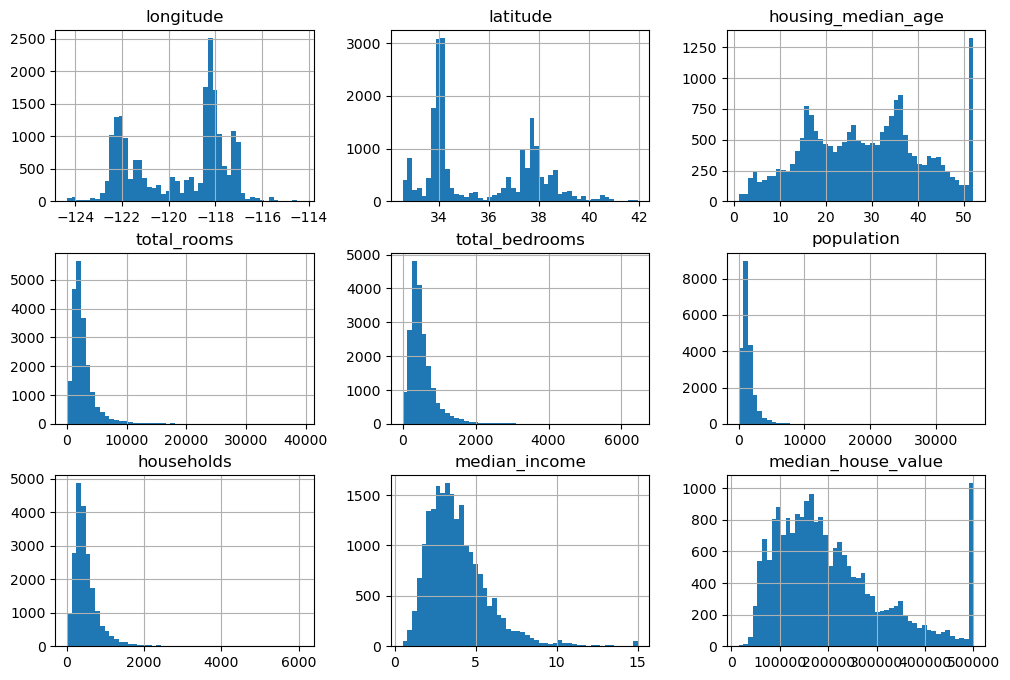

In [6]:
# show housing overview, sort of like pairplot
import matplotlib.pyplot as plt 
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [7]:
# Plot the data to visualize and get an overview
# extra code – the next 5 lines define the default font sizes
# plt.rc('font', size=14)
# plt.rc('axes', labelsize=14, titlesize=14)
# plt.rc('legend', fontsize=14)
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)

# housing.hist(bins=50, figsize=(12, 8))
# save_fig("attribute_histogram_plots")  # extra code
# plt.show()

In [8]:
# Grab out test set early on before analyzing data too much
# create a function to split the data into training and testing data given a ratio
def shuffle_and_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
# Use function to train_test_split
train_set, test_set = shuffle_and_split(housing, 0.2)
#Check length of both sets
display(len(train_set))
display(len(test_set))

16512

4128

In [10]:
# Use sklearns train_test_split to create a re-creatable train and test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [11]:
# Use the pd.cut function to create income categories to represent the income bracket
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.Inf],
                               labels=[1,2,3,4,5])

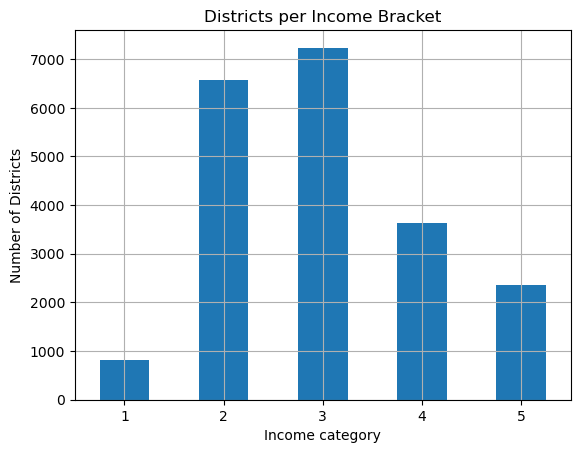

In [13]:
# plot to see relative distribution
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income category')
plt.ylabel('Number of Districts')
plt.title('Districts per Income Bracket')
plt.show()

In [14]:
# We want to generate multiple stratified splits for cross validation
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
# Use the first split
strat_train_set, strat_test_set = strat_splits[0]
# show train set 
strat_train_set.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3


In [18]:
# or use a simpler way to get stratisfied train/test splits
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing['income_cat'], random_state=42
)

In [19]:
# check income category proportions in test set
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [20]:
# drop income cat to revert data back to original set
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Explore and Visualize the Data to Gain Insights

In [18]:
# make a copy of the training set to be able to revert to it afterward
housing = strat_train_set.copy()

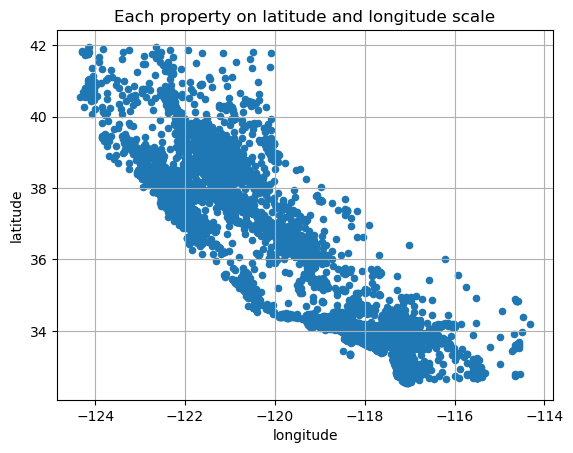

In [21]:
# visualize geographical data
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True)
plt.title('Each property on latitude and longitude scale')
plt.show()

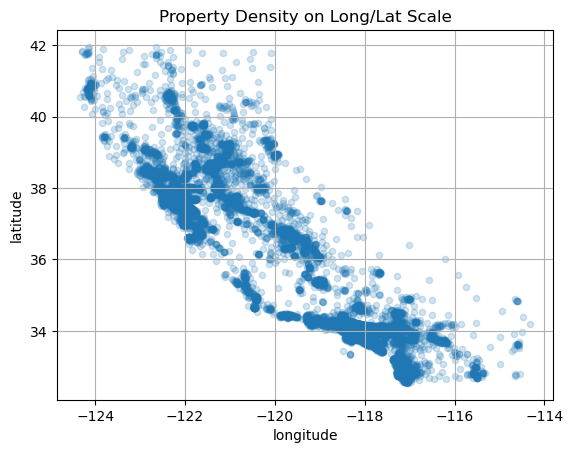

In [22]:
# set alpha to visuaize density
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.title('Property Density on Long/Lat Scale')
plt.show()

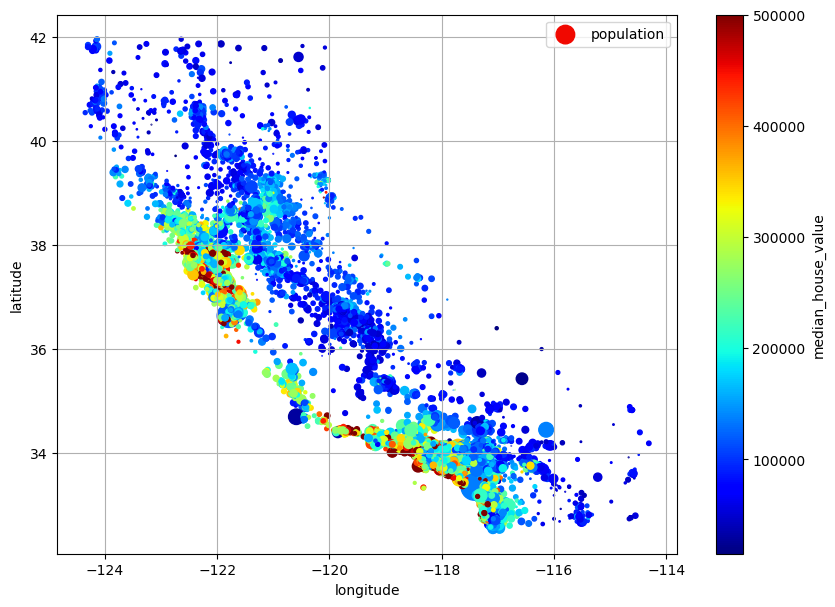

In [23]:
# go even further to visualize other parameters
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, s=housing['population']/100, label='population',
                c='median_house_value', cmap='jet', colorbar=True, 
                legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [24]:
# Look for correlation usings Pearsons 'r'
corr_matrix = housing.corr()

C:\Users\silva\AppData\Local\Temp\ipykernel_12148\125978209.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [25]:
# look at table
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Text(0.5, 1.0, 'Heatmap of Pearsons Correlation')

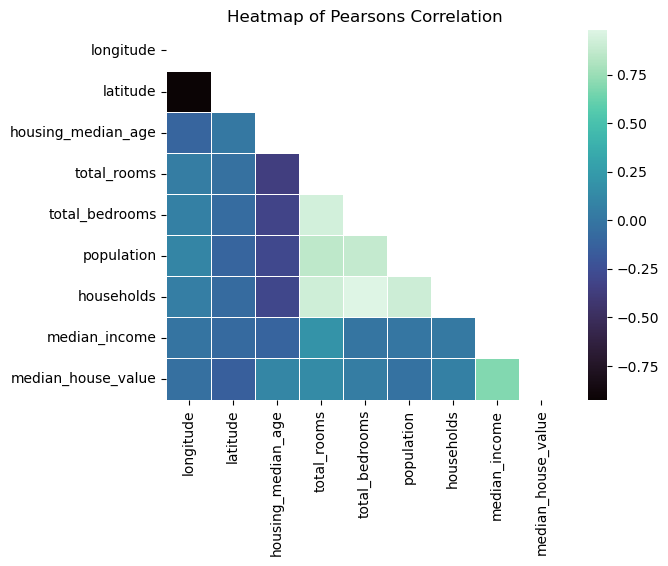

In [32]:
# plot a heatmap for the correlation of median house value
import seaborn as sns
matrix = np.triu(corr_matrix)
g = sns.heatmap(corr_matrix, cmap='mako', mask=matrix, cbar=True, linewidths=.42)
plt.title('Heatmap of Pearsons Correlation')

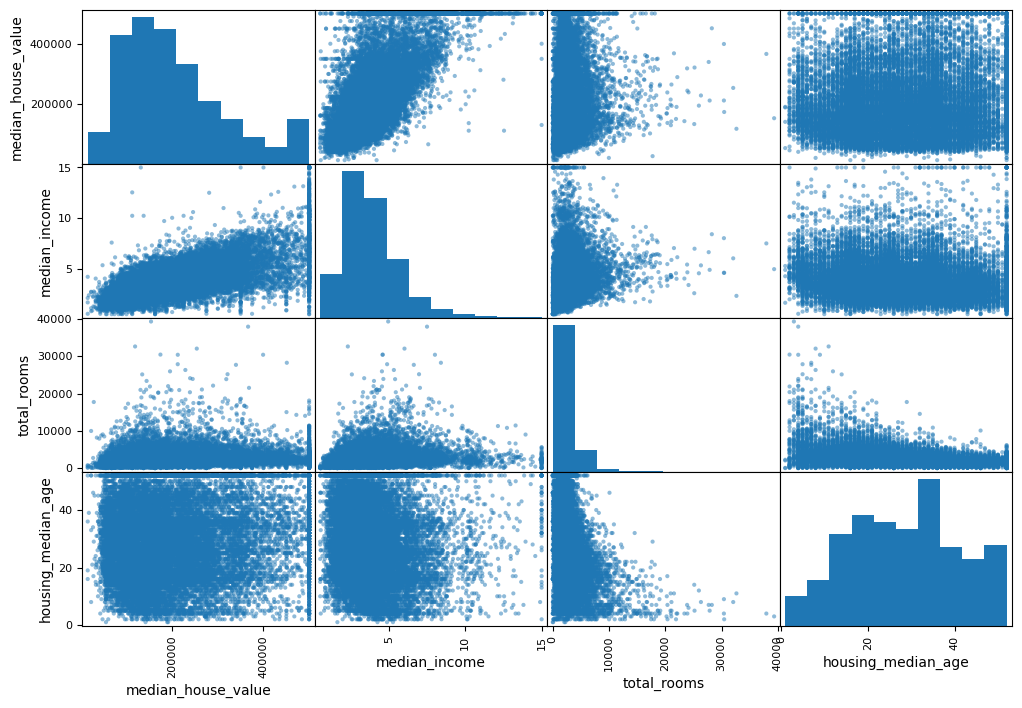

In [33]:
# plot the scatter matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8))

plt.show()

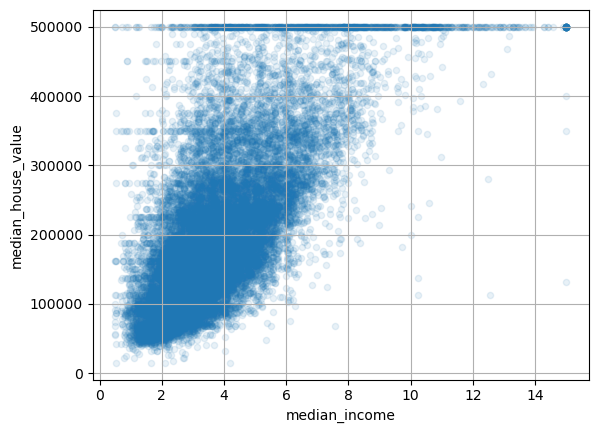

In [34]:
# zoom in on one plot to investigate
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)

plt.show()

In [41]:
# create new attributes to make more sense
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

# look at the new correlation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

C:\Users\silva\AppData\Local\Temp\ipykernel_12148\2269466882.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

Text(0.5, 1.0, 'New Heatmap of Pearsons Correlation')

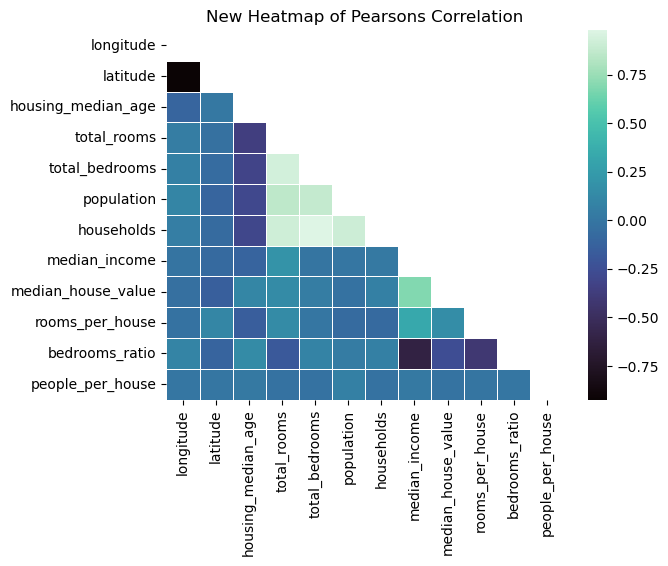

In [42]:
matrix = np.triu(corr_matrix)
h = sns.heatmap(corr_matrix, cmap='mako', mask=matrix, cbar=True, linewidths=.42)
plt.title('New Heatmap of Pearsons Correlation')

## Prepare a new copy of data for cleaning for a machine learning model

In [45]:
# make a new copy of data by creating the machine learning pipeline
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [44]:
# Clean the dataset - Options
# option 1 - drop all NaNs
# housing.dropna(subset=["total_bedrooms"], inplace=True)

# # option 2 - drop entire column all together
# housing.drop("total_bedrooms", axis=1)

# #option 3 - impute the NaNs to be the median of the target feature - best option
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [46]:
# Impute the right value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.select_dtypes(include=[np.number]) 

# train the imputer to fit to all numerical categories
imputer.fit(housing_num)

# call the imputer's statistics
print(imputer.statistics_)

# check that they are at the same as the median values
print(housing_num.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [51]:
# try another imputer for numeric variables
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# mean is the standard
it_imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=42,
        n_nearest_features=3,
        max_iter=3,
        sample_posterior=True,
    )
# fit the model
it_imputer.fit(housing_num)


IterativeImputer(add_indicator=True, max_iter=3, n_nearest_features=3,
                 random_state=42, sample_posterior=True)

In [52]:
# Use the imputer to account for any missing values
X = imputer.transform(housing_num) 
X_2 = it_imputer.transform(housing_num)

In [55]:
# wrap the predictions in a dataframe with proper column names
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=housing_num.index)
# preview head
display(housing_tr.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


#### Now that we have handled the missing values, lets handle the categorical columns

In [56]:
# handle the categorical variables
housing_cat = housing[["ocean_proximity"]]

# review data frame
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [57]:
# Use an ordinal encoder to change the categorical variables
from sklearn.preprocessing import OrdinalEncoder

# call an encoder instance
ordinal_encoder = OrdinalEncoder()

# fit transform to categorical feature
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# review coding for first 8 values
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [58]:
# check the list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
# try using a dummy encoder 
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [60]:
# review encoded matrix - saves a sparse matrix which is great for data storage
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [61]:
# convert to a dense numpy matrix
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [62]:
# look at categories for one hot encoder
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [63]:
# try using get dummies from pandas
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [64]:
# try out our one hot encoder on the new test df
cat_encoder.transform(df_test)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [73]:
# try with another unknown dataframe using the ignore function for handling unkowns
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})

cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [74]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [75]:
columns = cat_encoder.get_feature_names_out()

In [77]:
# # Finally transform to a dataframe
# df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown), 
#                          columns=columns,
#                          index=df_test_unknown.index)
# # Review test one hot encoded df
# df_output

## Feature Scaling

In [78]:
# import minmax scaler
from sklearn.preprocessing import MinMaxScaler

# call a scaler instance with rane from -1 - 1
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

# fit transform housing num
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [79]:
# use the StandarScaler module
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

housing_num_std_scaled = std_scaler.fit_transform(housing_num)

#### RBF Kernel

In [80]:
# kernl functiona for multimodel distibutions
""" if a feature is multimodel, meaning it has two separate distribution peaks, it might be necessary to bucketize the 
categories and use the buckets as IDs for learning

or

use an approach where you pick a distinct mode i.e. the median house age and compute the similarity between a feature and the 
distinct mode. You would use the radial basis function (Gaussian RBF) where the output value decays as it moves further from
the selected point.  

This kernel measures the Euclidean distance between points
"""
 
from sklearn.metrics.pairwise import rbf_kernel

# use the distinct age of 35 and measure the housing median age to the selected age of 35
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

## Inverse Transform

In [93]:
# Here we are just testing our inverse_transform function on some made up new data
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()

model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # pretending its new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

# review predicitons
predictions[:5]

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [92]:
# Here is a simpler method with TranformedTargetRegressor
from sklearn.compose import TransformedTargetRegressor
# load our model transformer
model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
new_predictions = model.predict(some_new_data)
# review predictions
new_predictions[:5]

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

In [94]:
# transform a heavily skewed dataset to its logarithm to standardize it
from sklearn.preprocessing import FunctionTransformer

# transform population to log
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

# review dataframe
log_pop.head(8)

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
1286,6.542472
18078,6.232448
4396,7.620215


In [96]:
# recreate a transformer for the housing median age rbf from 35
rbf_transformer = FunctionTransformer(rbf_kernel, 
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35_from_transformer = rbf_transformer.transform(housing[["housing_median_age"]])

# review age similarity
print(age_simil_35[:5])
print()
print(age_simil_35_from_transformer[:5])

[[2.81118530e-13]
 [8.20849986e-02]
 [6.70320046e-01]
 [8.48904403e-15]
 [9.04837418e-01]]

[[2.81118530e-13]
 [8.20849986e-02]
 [6.70320046e-01]
 [8.48904403e-15]
 [9.04837418e-01]]


In [97]:
# add feature to measure geographic distance between features
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

# review sf simil
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [98]:
# compare ratio between input features 0 and 1
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))


array([[0.5 ],
       [0.75]])

## Custom Classes for Custom transformers


In [99]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted # very important to validate inputs on all functions for production

# Create a clone of the standard scaler
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no args or kwargs
        self.with_mean = with_mean
        
    def fit(self, X, y=None): # y required but not used
        X = check_array(X) # checks X is an array with float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
        

In [100]:
# create a k-mean cluster class
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    from sklearn.metrics.pairwise import rbf_kernel
    from sklearn.cluster import KMeans
    def __init__(self, n_clusters=10, gamma=0.1, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return[f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [102]:
# use the custom transformer
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

# review similarities
similarities[:3].round(2)

c:\Users\silva\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

## Transformation Pipelines

In [103]:
# import pipleine class from sklearn
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [104]:
#visualize pipeline in place
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [105]:
# use the make pipeline without having to name transformers
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [106]:
# use our pipelines
housing_num_prepared = num_pipeline.fit_transform(housing_num)

# view first two rounds
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [107]:
# recover a nice dataframe
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)
# Review dataframe
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


#### Create a Transformer that handles both numerical and categorical columns

In [108]:
# create a transformer capable of handling the categorical and numerical columns together - ColumnTransformer
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]

cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [111]:
# Test quicker way instead of listing out all known numerical columns
num_attr_from_df = list(housing.select_dtypes(include=[np.number]).columns)
num_attr_from_df

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [112]:
# use a self-selecting class instead of listing out all of the column names
from sklearn.compose import make_column_selector, make_column_transformer

# make a quicker preprocessing pipeline
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [115]:
# apply to housing data
housing_prepared = preprocessing.fit_transform(housing)
# check feature names
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

## Combine all transformations into one handy pipeline 

In [116]:
# Define all functions from previous part of notebook into one line of code
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio'] # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)

In [118]:
# Prepare housing data from main pipeline
housing_prepared = preprocessing.fit_transform(housing)
# show shape
display(housing_prepared.shape)
# show features
display(preprocessing.get_feature_names_out())

c:\Users\silva\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(16512, 24)

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)